In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
from modules import *
from sklearn.model_selection import train_test_split
import pickle
from sklearn.datasets import fetch_olivetti_faces
from torch.utils.data import Dataset, DataLoader, TensorDataset
from skimage.transform import resize


def decoder(model, device, z):
    model.eval()
    z = Variable(torch.FloatTensor(z)).to(device)
    new_images = model.decode(z).squeeze_().data.cpu().numpy().transpose((1, 2, 0))
    return new_images

saved_model_path = './results_Olivetti_face'
# saved_model_path = './results_MNIST'

exp = 'Olivetti'
# exp = 'MNIST'

# use same ResNet Encoder saved earlier!
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 1024
CNN_embed_dim = 256
res_size = 224        # ResNet image size
dropout_p = 0.2       # dropout probability

epoch = 100


use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

# reload ResNetVAE model
resnet_vae = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)
resnet_vae.load_state_dict(torch.load(os.path.join(saved_model_path, 'model_epoch{}.pth'.format(epoch))))

print('ResNetVAE epoch {} model reloaded!'.format(epoch))

ResNetVAE epoch 100 model reloaded!


## Reconstruction

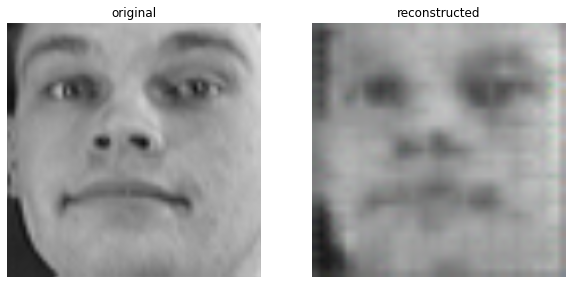

In [4]:
z_train = np.load(os.path.join(saved_model_path, 'z_{}_train_epoch{}.npy').format(exp, epoch))
X_train = np.load(os.path.join(saved_model_path, 'X_{}_train_epoch{}.npy').format(exp, epoch))

ind = 1
zz = torch.from_numpy(z_train[ind]).view(1, -1)
X = np.transpose(X_train[ind], (1, 2, 0))

new_imgs = decoder(resnet_vae, device, zz)

fig = plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(X)
plt.title('original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(new_imgs)
plt.title('reconstructed')
plt.axis('off')
plt.savefig("./reconstruction_{}.png".format(exp), bbox_inches='tight', dpi=600)
plt.show()

## Generate new images from latent points

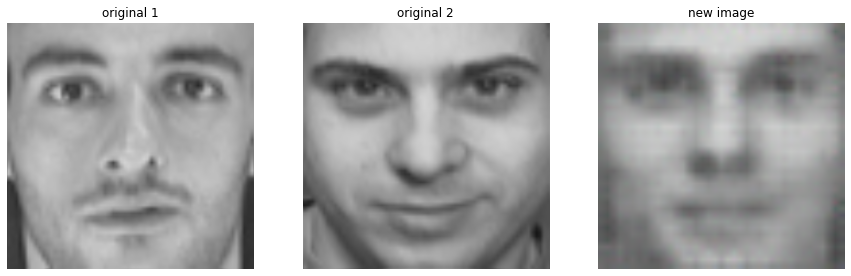

In [5]:
# choose two original images
sample1, sample2 = 0, 1
w = 0.4 # weight for fusing two images

X1 = np.transpose(X_train[-sample1], (1, 2, 0))
X2 = np.transpose(X_train[-sample2], (1, 2, 0))

# generate image using decoder
z_train = np.load(os.path.join(saved_model_path, 'z_{}_train_epoch{}.npy').format(exp, epoch))
z = z_train[-sample1] * w + z_train[-sample2] * (1 - w)
new_imgs = decoder(resnet_vae, device, torch.from_numpy(z).view(1, -1))

fig = plt.figure(figsize=(15, 15))

plt.subplot(1, 3, 1)
plt.imshow(X1)
plt.title('original 1')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(X2)
plt.title('original 2')
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(new_imgs)
plt.title('new image')
plt.axis('off')
plt.savefig("./generated_{}.png".format(exp), bbox_inches='tight', dpi=600)
plt.show()